<a href="https://colab.research.google.com/github/nhatanh81096/cs480student/blob/main/05/Anh_Vo_CS480_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

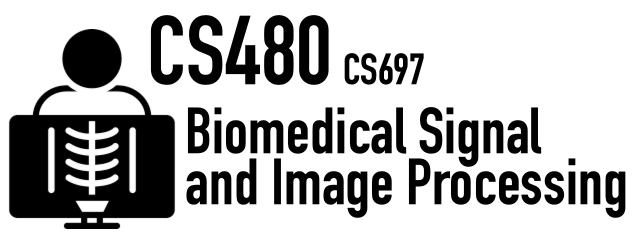
#Assignment 5

In [1]:
# In this assignment, we will visualize and explore a CT scan!

In [2]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# we are using pydicom, so lets install it!
!pip install pydicom

     |████████████████████████████████| 1.9MB 5.7MB/s 


**Task 1**: Download and visualize data with SliceDrop! [20 Points]

In [4]:
# Please download https://cs480.org/data/ct.zip and extract it on your computer!
# This is a CT scan of an arm in DICOM format.

In [5]:
# 1) Let's explore the data without loading it.
# TODO: Without loading the data, how many slices are there?

There are 220 slices

In [6]:
# 2) Let's visualize the data with SliceDrop! 
# Go to https://slicedrop.com and drag'n'drop all .dcm files into the browser.
# Please use the 2D sliders to show axial, sagittal, and coronal slices in 3D.

In [7]:
# TODO Please post a screenshot of SliceDrop's 3D View in the text box below by 
# using the Upload image button after double-click.

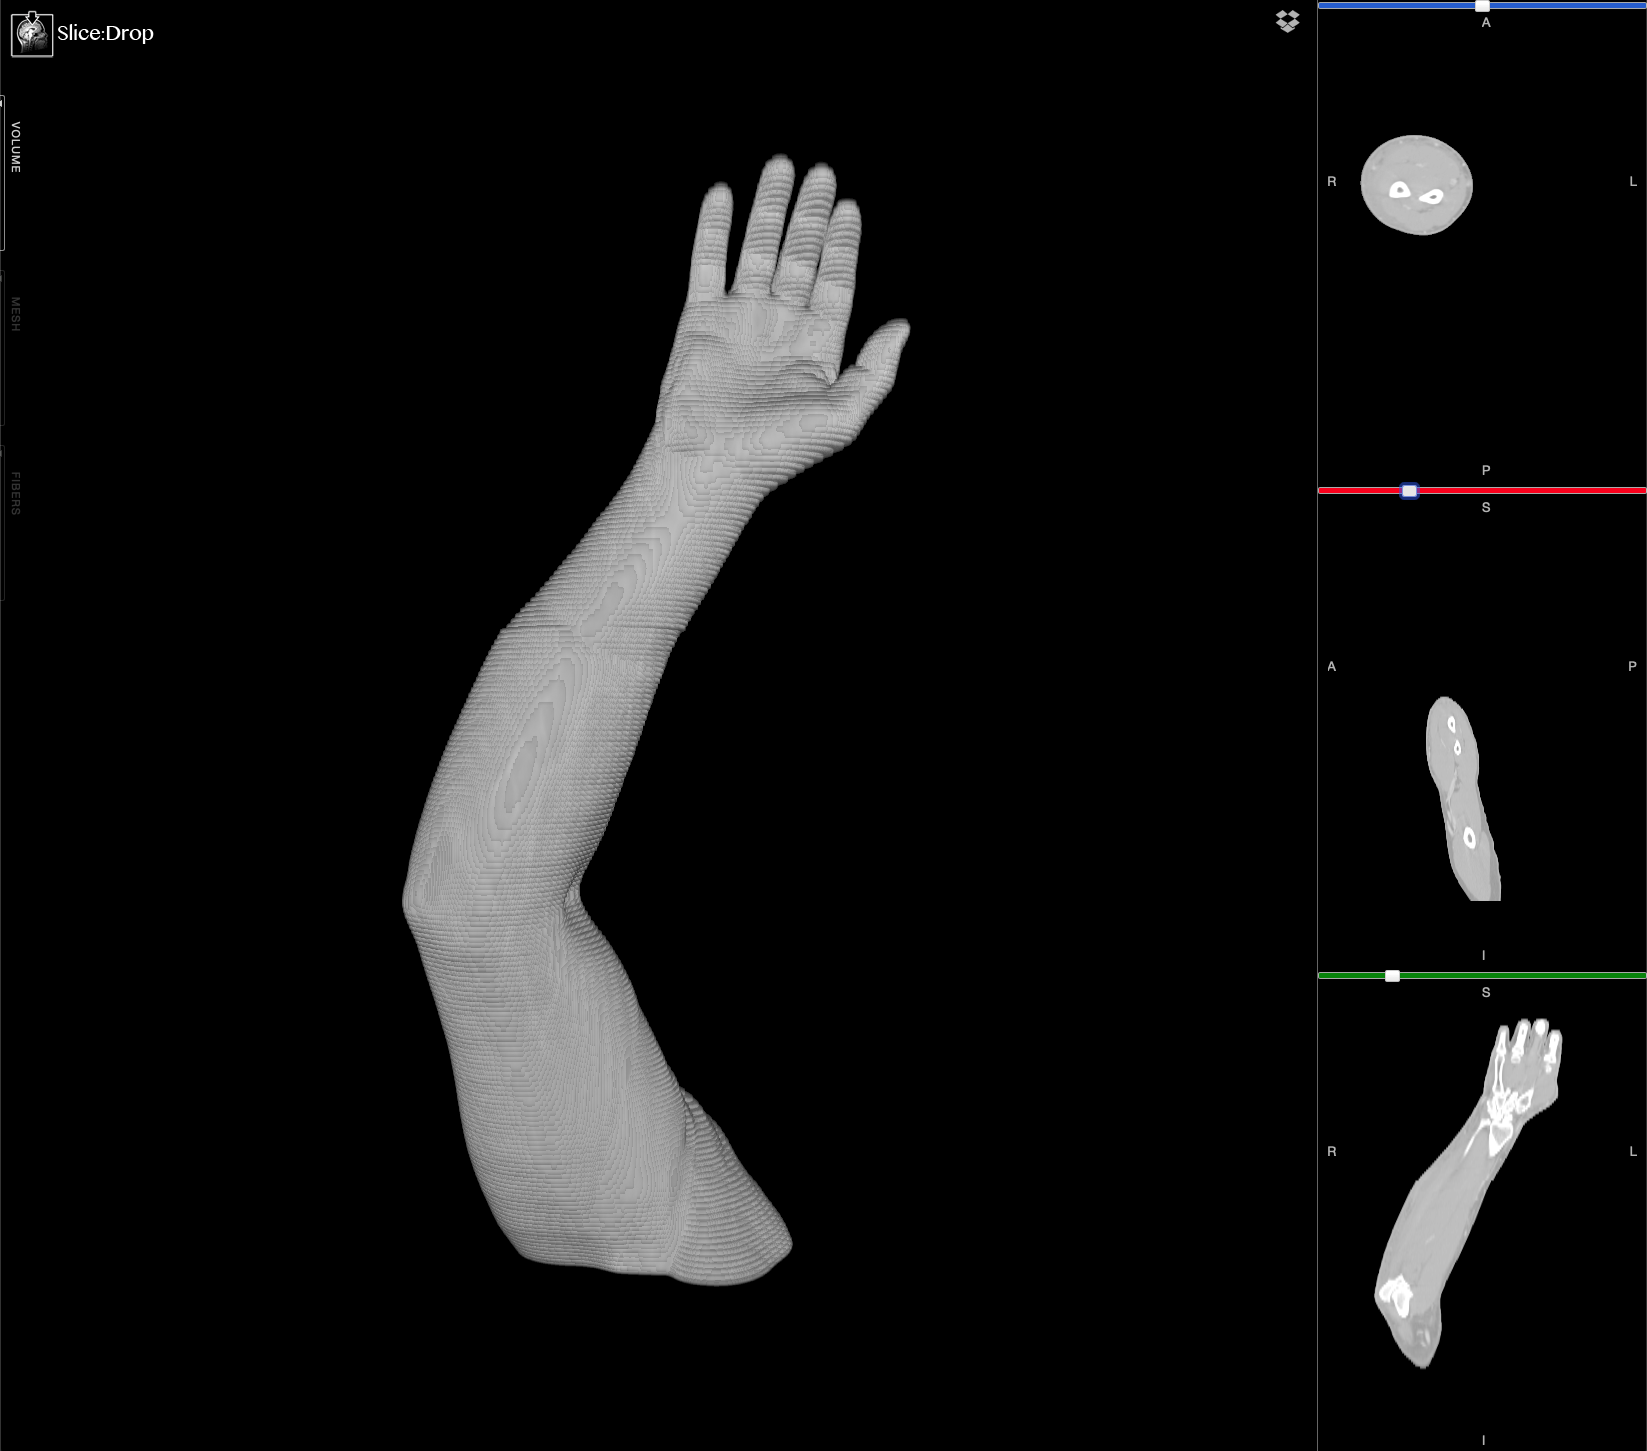

Axial

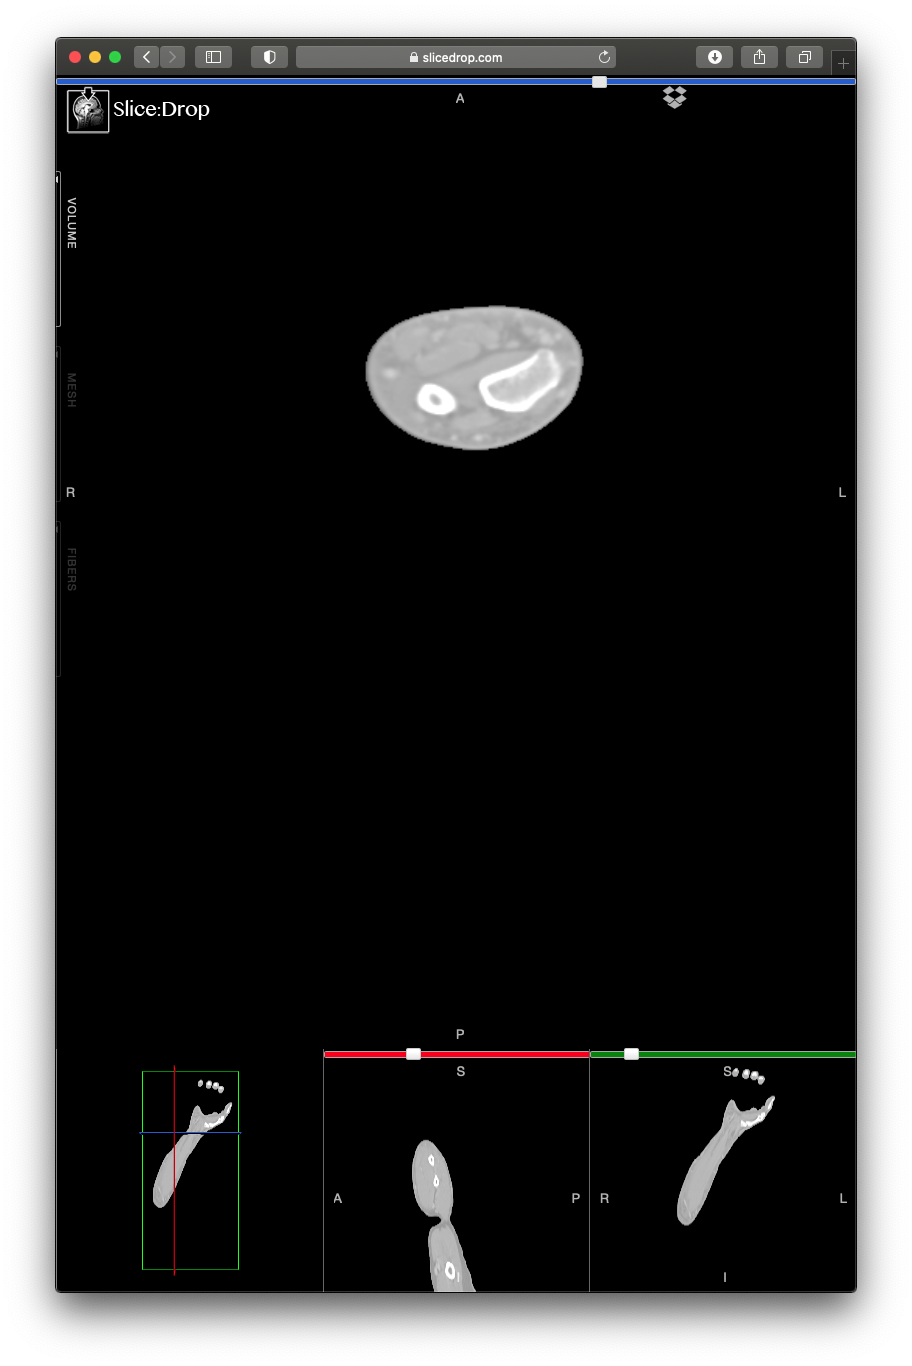

Sagittal

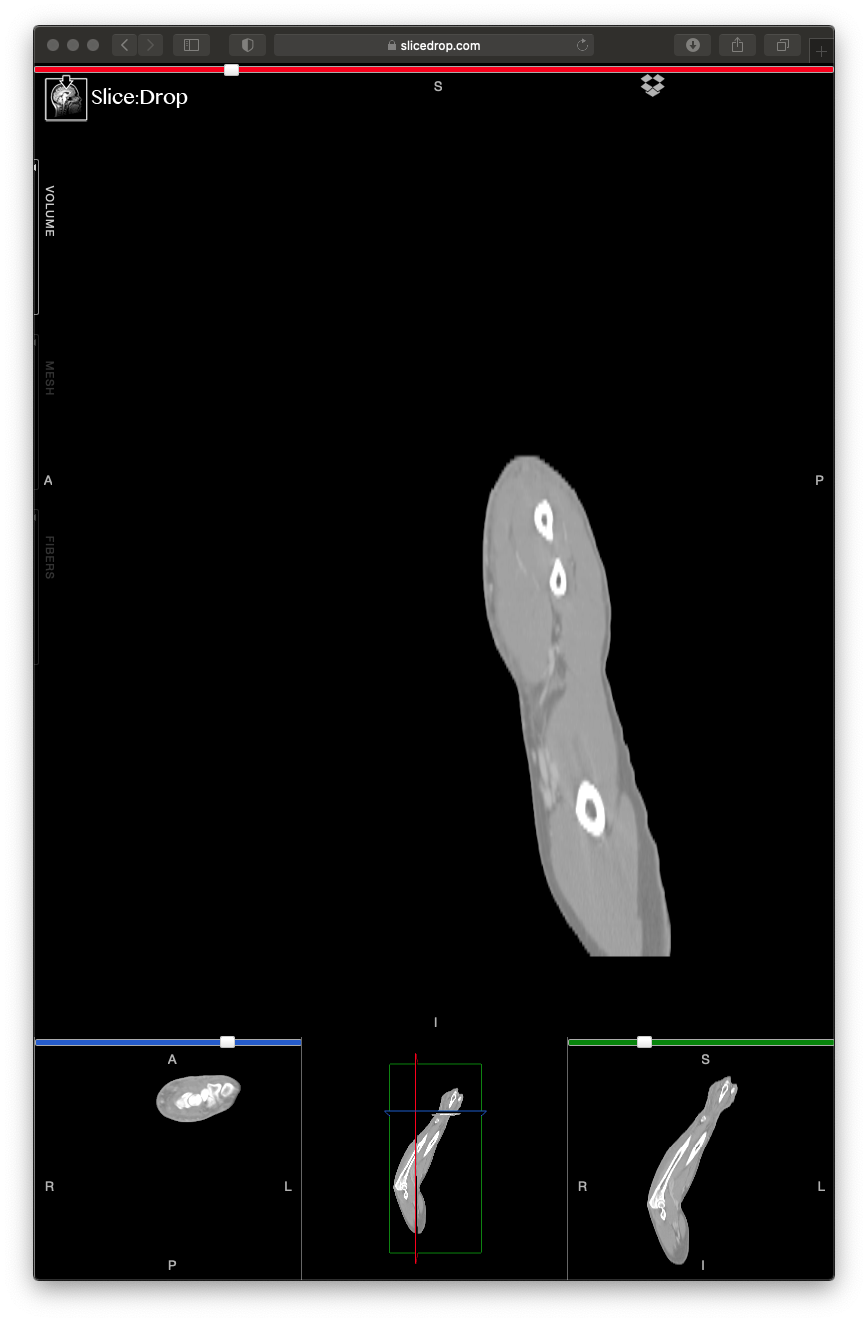

Coronal

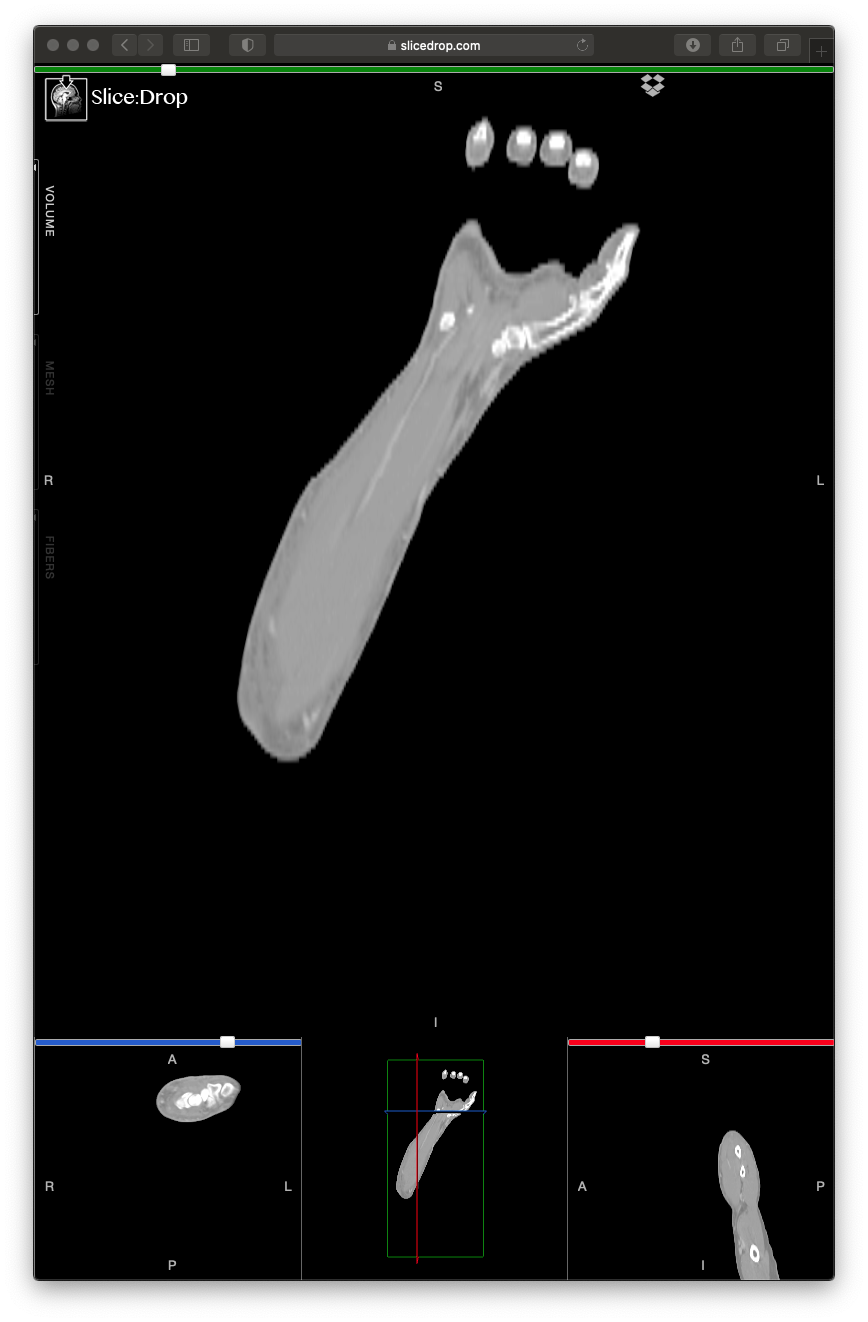

**Task 2**: Load the data using pydicom as a 3D volume and then reslice it! [35 Points]

In [8]:
# TODO: Please upload ct.zip using the file panel on the left.
# Then use the following snippet to extract the data.

In [9]:
!curl -O https://cs480.org/data/ct.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5710k  100 5710k    0     0  4987k      0  0:00:01  0:00:01 --:--:-- 4987k


In [10]:
import zipfile
with zipfile.ZipFile('ct.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [11]:
# 1) Now loop through all the DICOM files and store them in a 3D numpy array.
# Hint: You can either store them in a list first or read the dimensions of a
# single image slice to properly create the 3D numpy array.
# Hint 2: os.listdir(DIR) gives a list of filenames in a directory.
# Hint 2b: This list is not sorted - make sure you sort it.
# Hint 3: The dcmread function loads a single DICOM file.
# Hint 4: You can then use .pixel_array to access the image data.

In [12]:
from pydicom import dcmread

In [13]:
from os import listdir
from os.path import join

In [14]:
# TODO: YOUR CODE FOR LOADING THE VOLUME AS A 3D NUMPY ARRAY

In [15]:
files = listdir("ct")
files.sort()
slices = [dcmread(join("ct", file)) for file in files]
image_volume = np.array([s.pixel_array for s in slices])

In [16]:
image_volume.shape

(220, 454, 512)

In [17]:
# 2) Now create and show axial, sagittal, and coronal slices from the 3D volume.
# Hint: Please use imshow(XX, cmap='gray') to show the image.

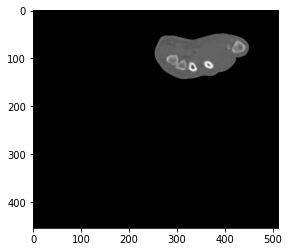

In [18]:
# TODO: YOUR CODE FOR AXIAL
imshow(image_volume[50,:,:], cmap='gray')

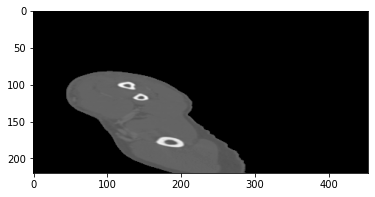

In [19]:
# TODO: YOUR CODE FOR SAGITTAL
imshow(image_volume[:,:,150], cmap='gray')

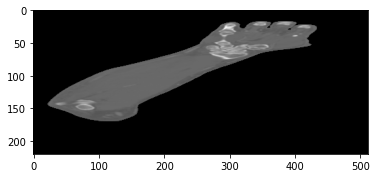

In [20]:
# TODO: YOUR CODE FOR CORONAL
imshow(image_volume[:,100,:], cmap='gray')

**Task 3**: Use the Window/Level-technique to visualize the data! [45 Points]

In [21]:
# We will now enhance the visualization from above by performing 
# Window/Level adjustment.
# Here is one way of doing that:
#   vmin = level - window/2
#   vmax = level + window/2
#   plt.imshow(hu_pixels + rescale, cmap='gray', vmin=vmin, vmax=vmax)
#   plt.show()

In [22]:
# 1) Please load the Window/Level values from the DICOM file,
# print these values, and then visualize one slice with window/level adjustment.
# Hint: The DICOM header has the following tags.
#   (0028, 1050) Window Center 
#   (0028, 1051) Window Width
# Hint 2: You can use slice[key].value to access DICOM tag values.
# Hint 3: (0028, 1052) Rescale Intercept might be important.

In [23]:
# TODO: YOUR CODE
window_center = slices[0].WindowCenter
window_width = slices[0].WindowWidth
rescale_intercept = slices[0].RescaleIntercept
rescale_slope = slices[0].RescaleSlope
print(f"Window center: {window_center}, Window width: {window_width}, Rescale intercept: {rescale_intercept}, Rescale slope: {rescale_slope}")

Window center: 30, Window width: 410, Rescale intercept: -1024, Rescale slope: 1.000000


In [24]:
# 2) Play around with different Window/Level values that enhance
# the visualization.

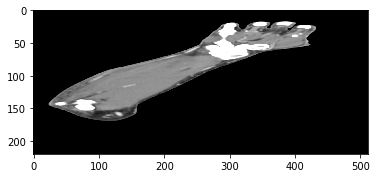

In [25]:
vmin = window_center - window_width/2
vmax = window_center + window_width/2
hu_pixels = image_volume * rescale_slope + rescale_intercept
imshow(hu_pixels[:,100,:], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

In [ ]:
# Which values make sense and why?

In [ ]:
# TODO: YOUR ANSWER

It depends on the type of tissue you want to visualize. 

In our case, Level equals to Window center, and Window equals to Window width make sense.

These values were defined in the DICOM file header, so they should be specific to this image. 

In addition, since this is a CT image of an arm, so most of the stuff should be fat and soft tissue. Thus, the level around 30 and the width around 400 would cover the area of interest.

**Bonus**: Create segmentations (label maps) for the volume using thresholding HU! [33 Points]

In [26]:
# Similar to Window/Level adjustment for visualization, we can threshold
# the volume to highlight the following components using the Hounsfield Units:
# 1) Fat
# 2) Soft Tissue
# 3) Bones
#
# Please create 3 segmentation masks for these structures.
# Then, please visualize each 3 slices per structure to showcase the segmentation.
# Hint: As a reminder, the following code allows thresholding of a numpy array.
#   new_mask = imagevolume.copy()
#   new_mask[new_mask < XXX] = 0
# Hint2: You might need to cast new_mask to int16 not uint16.

In [27]:
def create_mask(image, low, high):
  mask = image.copy().astype(int16)
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if low <= mask[i][j] <= high:
        mask[i][j] = 0
      else:
        mask[i][j] = 1
  return mask

In [49]:
def show_masks(low, high):
  fig, axs = plt.subplots(3,3,figsize=[30,30])

  for i, s in enumerate([100, 125, 150]):
    mask_0 = create_mask(hu_pixels[s,:,:], low, high)
    mask_1 = create_mask(hu_pixels[:,s,:], low, high)
    mask_2 = create_mask(hu_pixels[:,:,s], low, high)
  
    axs[i][0].imshow(mask_0, cmap='gray')
    axs[i][1].imshow(mask_1, cmap='gray')
    axs[i][2].imshow(mask_2, cmap='gray')
    
    axs[i][0].set_title(f"Slice {s} - Axial", fontsize=15)
    axs[i][1].set_title(f"Slice {s} - Saggital", fontsize=15)
    axs[i][2].set_title(f"Slice {s} - Coronal", fontsize=15)

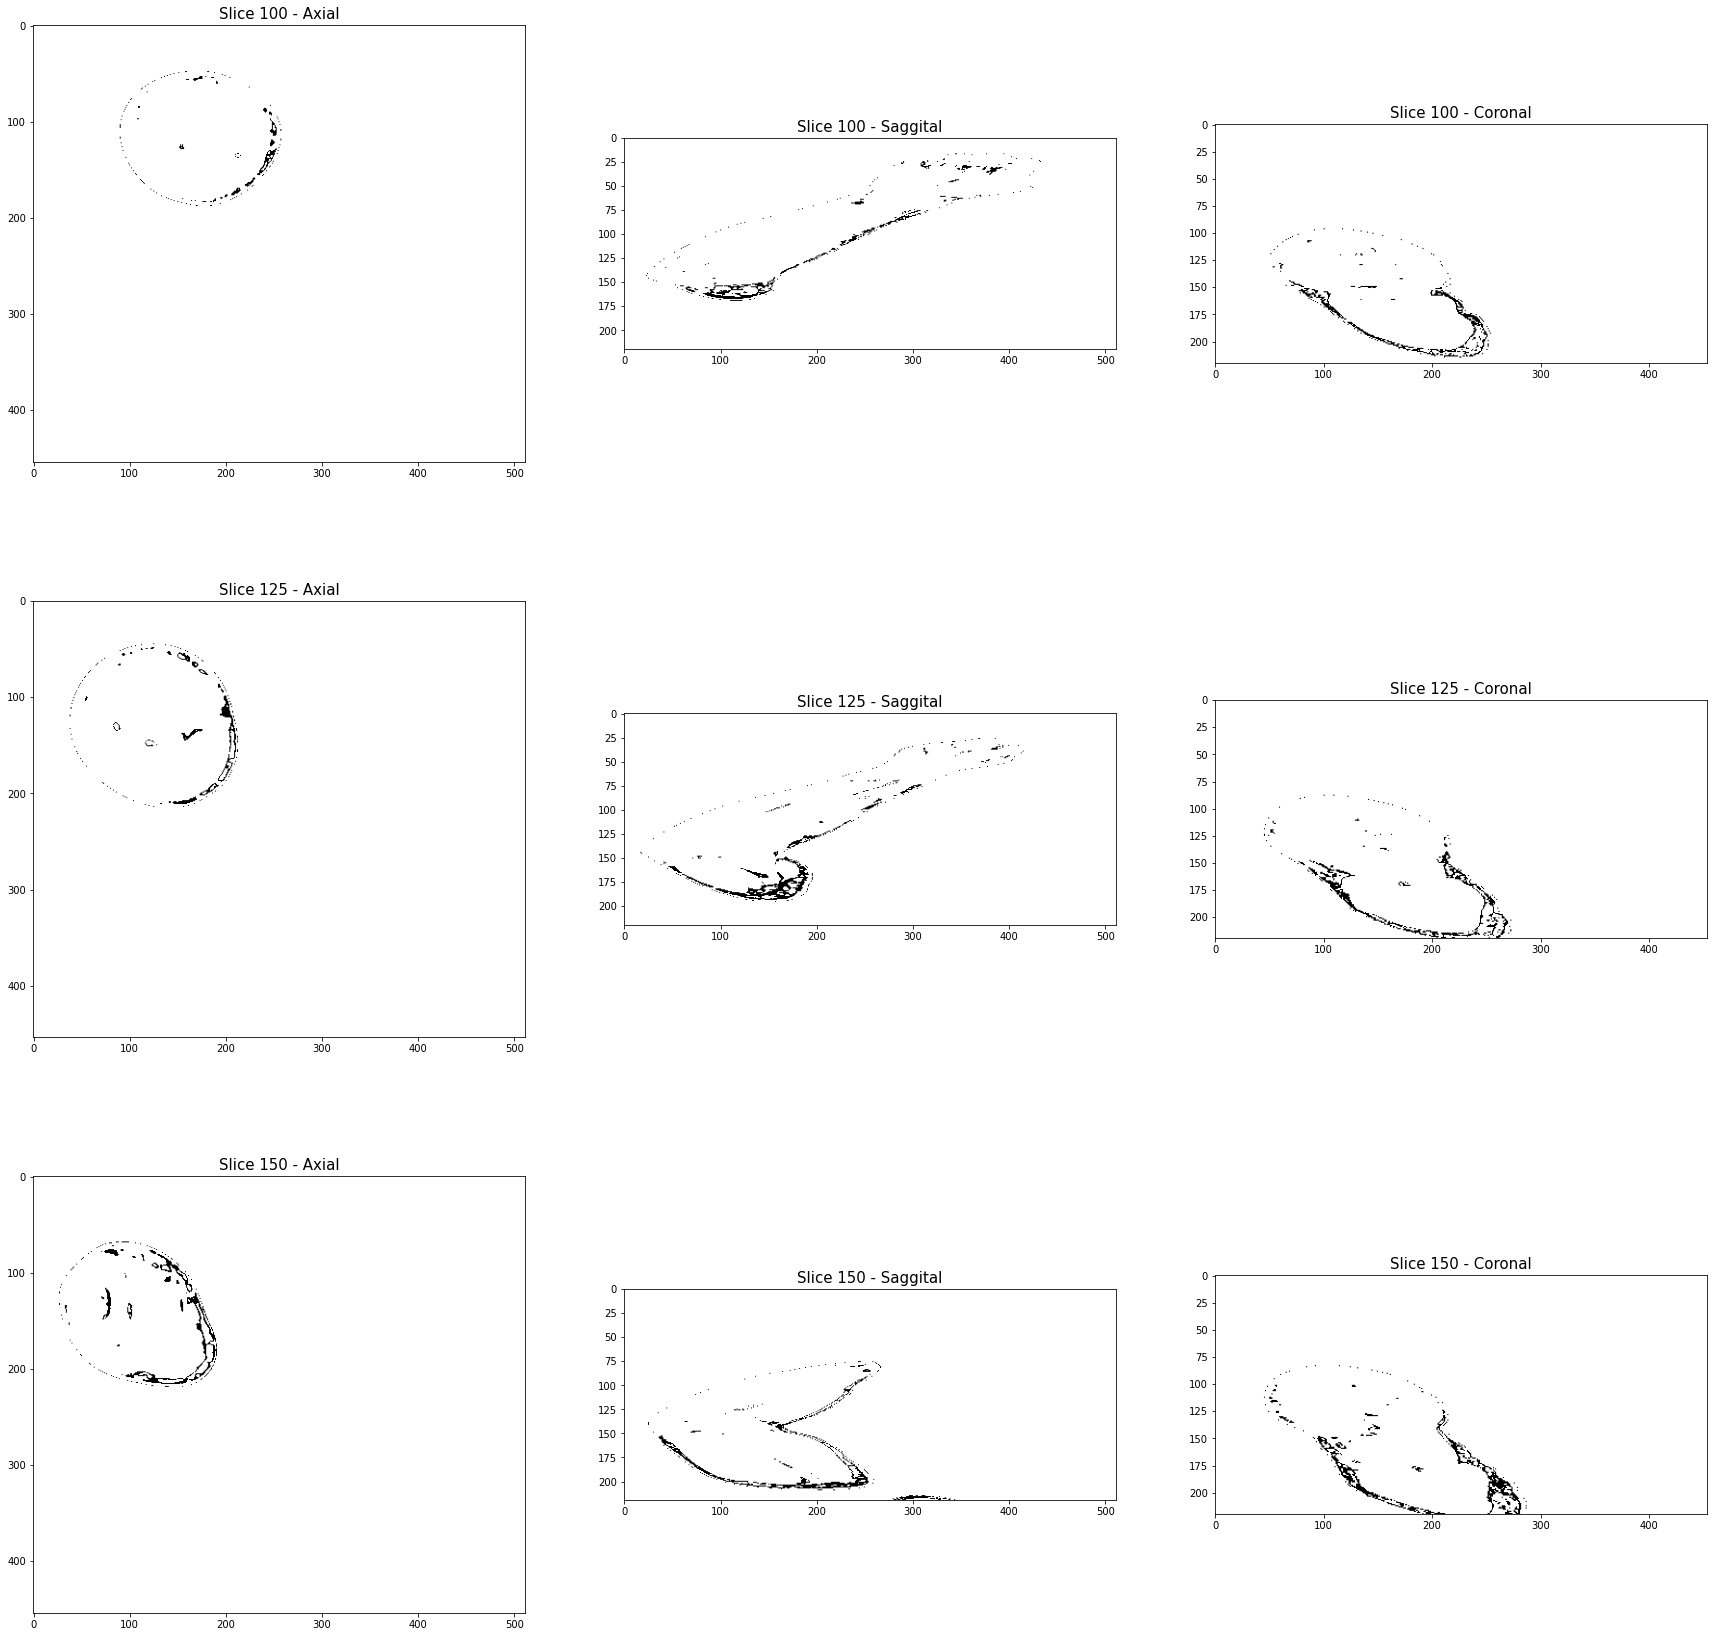

In [50]:
# TODO: YOUR CODE TO SEGMENT FAT
# FAT HU range is from -60 to -100
show_masks(-100, -60)

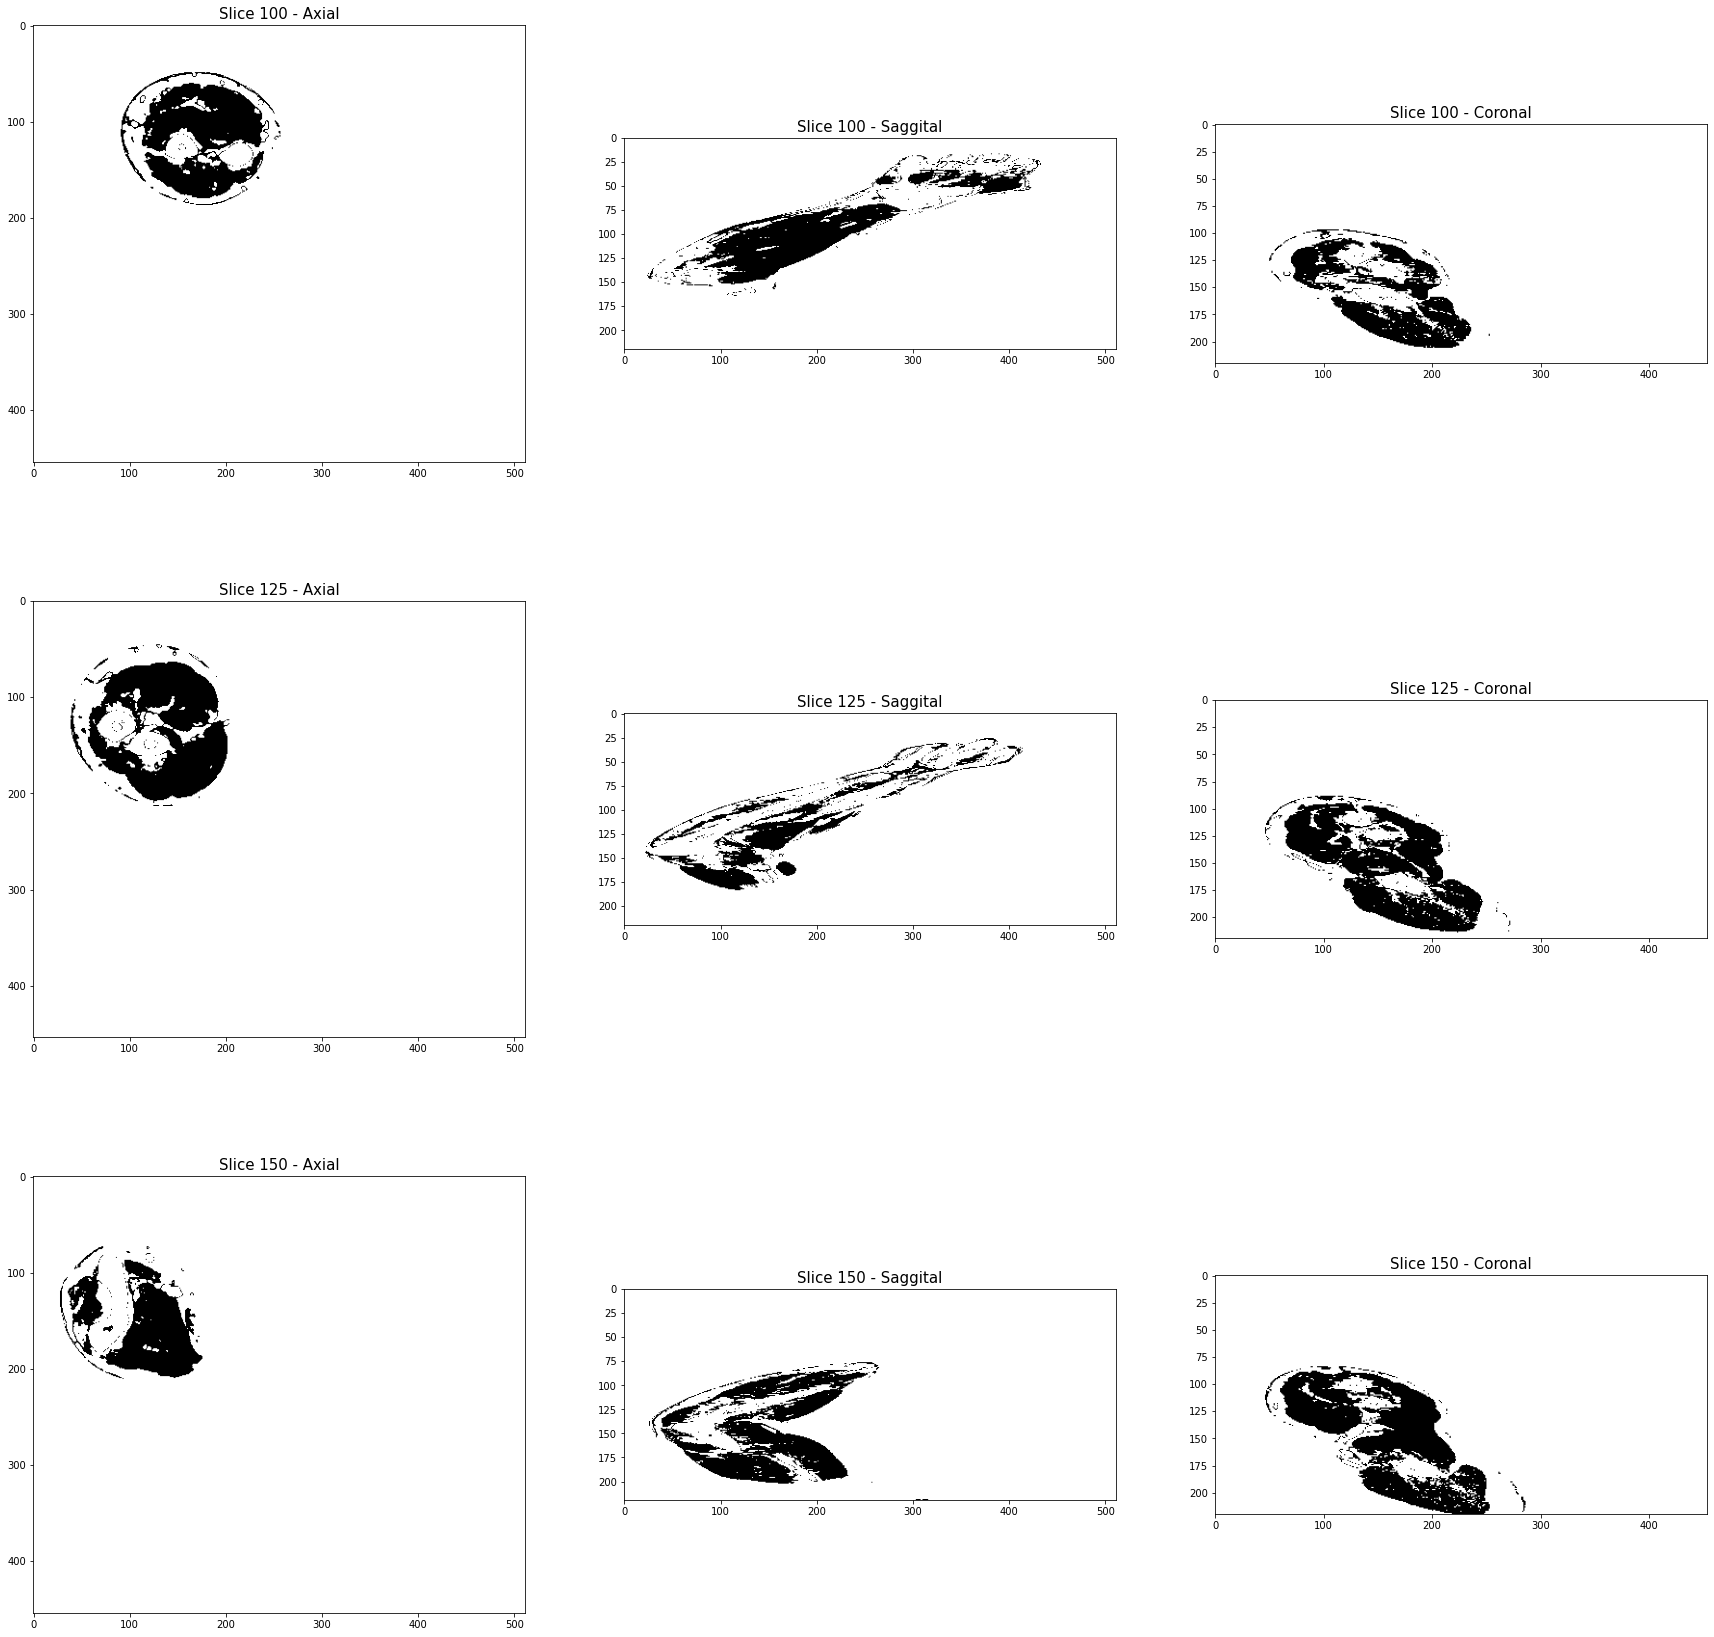

In [51]:
# TODO: YOUR CODE TO SEGMENT SOFT TISSUE
# SOFT TISSUE HU range is from +40 to +80
show_masks(40, 80)

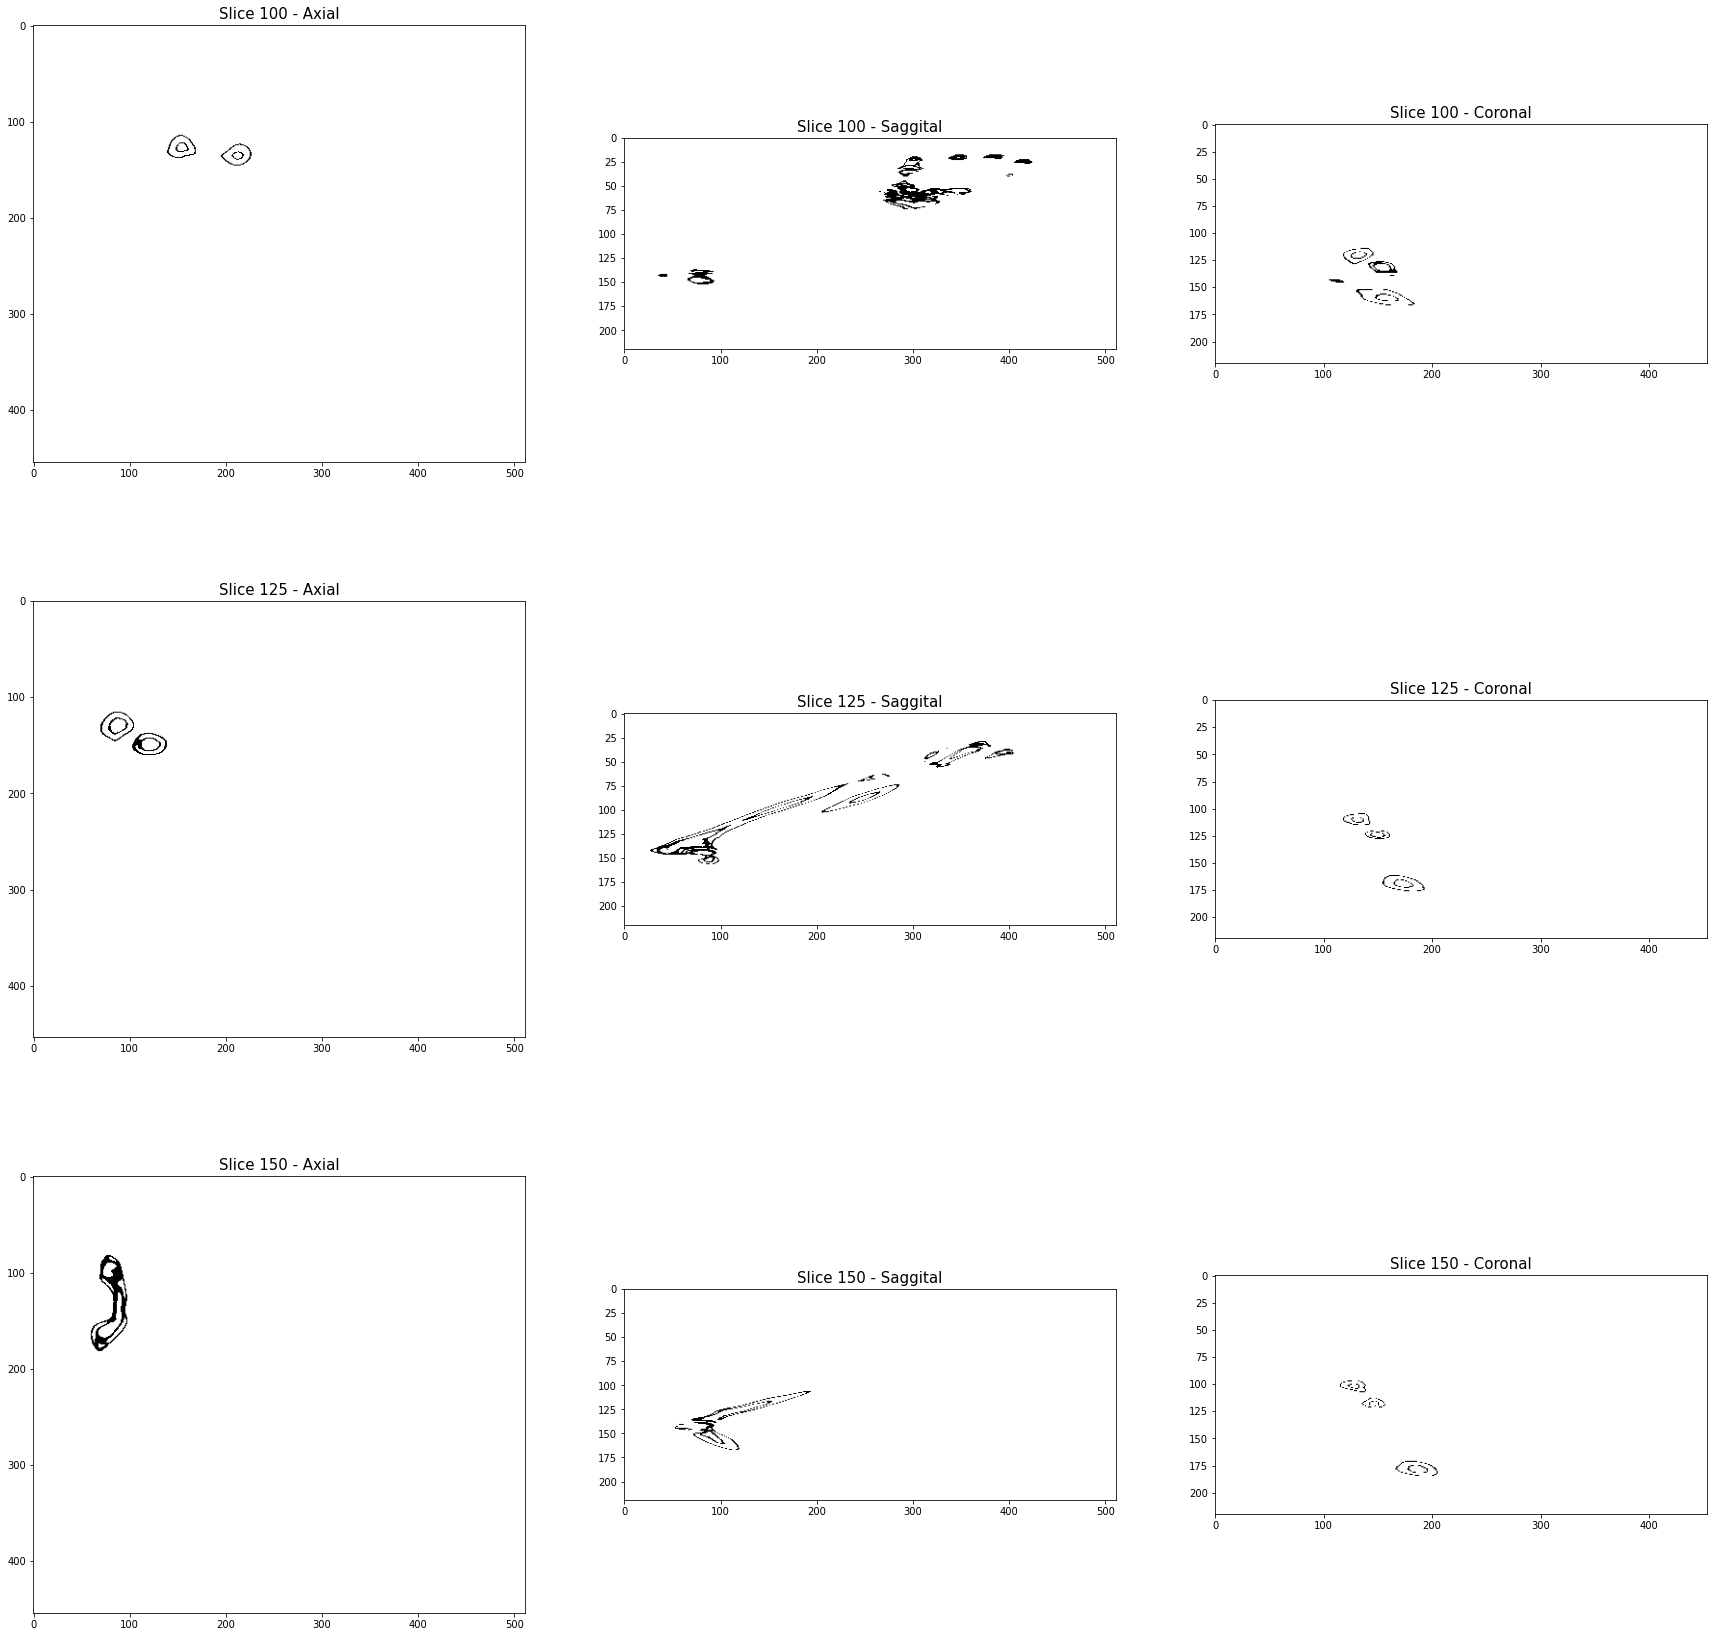

In [52]:
# TODO: YOUR CODE TO SEGMENT BONES
# BONE HU range is from +400 to +1000
show_masks(400, 1000)

In [ ]:
# Are the segmentations good?

In [ ]:
# TODO: YOUR ANSWER

The segmentations are not really good for the case of fat (or there is no fat at all)

The segmentations are pretty good in the case of soft tissue and bone



In [ ]:
#
# Thank you and Great job!!
#
#                _.---._
#              .'       `.
#              :)       (:
#              \ (@) (@) /
#               \   A   /
#                )     (
#                \"""""/
#                 `._.'
#                  .=.
#          .---._.-.=.-._.---.
#         / ':-(_.-: :-._)-:` \
#        / /' (__.-: :-.__) `\ \
#       / /  (___.-` '-.___)  \ \
#      / /   (___.-'^`-.___)   \ \
#     / /    (___.-'=`-.___)    \ \
#    / /     (____.'=`.____)     \ \
#   / /       (___.'=`.___)       \ \
#  (_.;       `---'.=.`---'       ;._)
#  ;||        __  _.=._  __        ||;
#  ;||       (  `.-.=.-.'  )       ||;
#  ;||       \    `.=.'    /       ||;
#  ;||        \    .=.    /        ||;
#  ;||       .-`.`-._.-'.'-.       ||;
# .:::\      ( ,): O O :(, )      /:::.
# |||| `     / /'`--'--'`\ \     ' ||||
# ''''      / /           \ \      ''''
#          / /             \ \
#         / /               \ \
#        / /                 \ \
#       / /                   \ \
#      / /                     \ \
#     /.'                       `.\
#    (_)'                       `(_)
#     \\.                       .//
#      \\.                     .//
#       \\.                   .//
#        \\.                 .//
#         \\.               .//
#          \\.             .//
#     jgs   \\.           .//
#           ///)         (\\\
#         ,///'           `\\\,
#        ///'               `\\\
#       ""'                   '""